# 1. Introduction

This work has as objetive make an analysis on the public bids of the Brazilian State Rio Grande do Sul. Also, an Anomaly Detection Model is built to identify suspicious items bought on bids.<br>
The datasets contain text and numerical features about the bids description and items bought for the years of 2016 tp 2019.<br>
For the analysis, the text features are analyzed for specific recurrent set of words, like items and public organ names, and for numerical features, the item costs.<br>



# 2. Load Modules and Variable Environments

In [79]:
%reload_ext autoreload
%autoreload 1
# Load custom local packages
import sys
import os
sys.path.append(os.path.abspath('..'))
# Local Packages
%aimport src.features
from src.features.build_features import build_features
from src.nlp_utils.clean_text import clean_text
from src.nlp_utils.extract_ngrams import extract_ngrams
from src.data.load_data import load_data
from src.data.final_data import build_pred_data
# Standard Packages
import pandas as pd
import numpy as np
from IPython.display import HTML
import gc
from collections import Counter
# Visualization Packages
import hvplot.pandas
# Paths and Config constants
DATA_PATH = os.path.abspath('..')+os.sep+'data'
FIG_PATH = os.path.abspath('..')+os.sep+'reports'+\
            os.sep+'figures'+os.sep
YEARS = [2016, 2017, 2018, 2019]
K_FOLDS = 5
CUSTOM_STOPWORDS = ['aquisição', 'fornecimento', 'kg', 'tk'
                    'gr', 'sc', 'conforme', 'anexo', 'edital',
                    'tipo', 'área', 'lote', 'aprox', 'porto',
                    'serviços','cor',  'rua', 'alegrers', 'item',
                    'uso', 'serviço', 'cfeespanexa',  'numero',
                     'privativa',  'vii', 'matrícula', 'objeto',
                     'amt', 'mca', 'm³h', 'amt', 'solução', 'padrão',
                     'vazão', 'objetos', 'mgml', 'termo', 'referência',
                     'registro', 'preços', 'outro', 'bens', 'ano',
                     'respectivo', 'constantes', 'humana', 'ref',
                     'etapa', 'deste', 'nao', 'aparelhos', 'protecao',
                     'preparacao']

# 3. Build Required Features

In [22]:
"""
bid_features = ['NR_LICITACAO', 'CD_ORGAO', 'NM_ORGAO', 'DS_OBJETO',
                 'TP_OBJETO', 'ANO_LICITACAO']
item_features = ['NR_LICITACAO', 'CD_ORGAO', 'DS_ITEM', 'VL_UNITARIO_HOMOLOGADO']

build_features(dataset='licitacao', data_path=DATA_PATH, cols=bid_features, values=YEARS)
print('=' * 18)
build_features(dataset='item', data_path=DATA_PATH, cols=item_features, values=YEARS)
"""

"\nbid_features = ['NR_LICITACAO', 'CD_ORGAO', 'NM_ORGAO', 'DS_OBJETO',\n                 'TP_OBJETO', 'ANO_LICITACAO']\nitem_features = ['NR_LICITACAO', 'CD_ORGAO', 'DS_ITEM', 'VL_UNITARIO_HOMOLOGADO']\n\nbuild_features(dataset='licitacao', data_path=DATA_PATH, cols=bid_features, values=YEARS)\nprint('=' * 18)\nbuild_features(dataset='item', data_path=DATA_PATH, cols=item_features, values=YEARS)\n"

# 4. Load Processed Data

In [23]:
bid, item = load_data(data_path=DATA_PATH, years=YEARS)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,DS_OBJETO
0,84100,PM DE ESPERANÇA DO SUL,4.0,2016,Aquisição de merenda escolar
1,82701,CM DE XANGRI-LÁ,1.0,2016,AQUISIÇÃO DE PROTOCOLADORA E FRAGMENTADORA DE ...
2,84100,PM DE ESPERANÇA DO SUL,6.0,2016,Aquisição de materiais de limpeza para as dive...


Number of samples: 82190
 


,CD_ORGAO,NR_LICITACAO,DS_ITEM,VL_UNITARIO_HOMOLOGADO,ANO_LICITACAO
0,77200,15.0,"Pneu 1000/20 liso radial, dianteiro, 16 lonas,...",1430.0,2016
1,77200,15.0,"Pneu 12.4x24 garra baixa, 10 lonas",1258.0,2016
2,77200,15.0,Pneu 1400x24 mínimo 12 lonas,1998.0,2016


Number of samples: 3079700
 
There are no problems with Code and Organ names.
 
There are 843 Public Organs in the Dataset.


In [24]:
display(HTML('<b>Missing values for Bids'), bid.isnull().sum())
print(' ')
display(HTML('<b>Missing values for Items'), item.isnull().sum())

CD_ORGAO         0
NM_ORGAO         0
NR_LICITACAO     0
ANO_LICITACAO    0
DS_OBJETO        0
dtype: int64

CD_ORGAO                       0
NR_LICITACAO                   0
DS_ITEM                        1
VL_UNITARIO_HOMOLOGADO    604785
ANO_LICITACAO                  0
dtype: int64

# 5. Exploratory Data Analysis
## 5.1 General Analysis

In [25]:
sf = bid['ANO_LICITACAO'].value_counts()
df = pd.DataFrame({'Year': sf.index,
                    'Total': sf.values})
df.sort_values(by=['Year'], inplace=True)

fig = df.hvplot.line(x='Year', y=['Total'], grid=True,
                xticks=np.arange(2016, 2019.5, 1).tolist(),
                title='Figure 1 - Total Bids by Year (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-1.png')
fig

:Curve   [Year]   (Total)

In [26]:
df = item.groupby(['ANO_LICITACAO']).sum('VL_UNITARIO_HOMOLOGADO').\
    drop(['NR_LICITACAO'], axis=1).reset_index().sort_values(by=['ANO_LICITACAO'])

fig = df.hvplot.line(x='ANO_LICITACAO', y=['VL_UNITARIO_HOMOLOGADO'], grid=True,
                xticks=np.arange(2016, 2019.5, 1).tolist(), yformatter='%.1d',
                xlabel='Year', ylabel='Total',
                title='Figure 2 - Total Bid Costs by Year (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-2.png')
fig

:Curve   [ANO_LICITACAO]   (VL_UNITARIO_HOMOLOGADO)

In [27]:
top_n = 5
sf = bid['NM_ORGAO'].value_counts().head(top_n)
# Wil be used later
sf_cd = bid['CD_ORGAO'].value_counts().head(top_n)
top10_cd = sf_cd.index.tolist()
df = pd.DataFrame({'Public Organ': sf.index,
                    'Total': sf.values})

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True, width=900,
                    xticks=np.arange(0, 2000, 300).tolist(), grid=True,
                    title='Figure 3 - Top 10 Public Organs by Number of Bids (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-3.png')
fig
                

:Bars   [Public Organ]   (Total)

In [28]:
sf = item.groupby(['CD_ORGAO']).sum('VL_UNITARIO_HOMOLOGADO').\
    drop(['NR_LICITACAO'], axis=1).reset_index().\
    sort_values(by=['VL_UNITARIO_HOMOLOGADO'],
                ascending=False).head(top_n)

cdo_list = sf['CD_ORGAO'].tolist()
po_names = []

for cdo in cdo_list: 
    po_list = bid.query('CD_ORGAO == @cdo')
    po_name = po_list['NM_ORGAO'].unique()
    po_names.append(po_name[0])

df = pd.DataFrame({'Public Organ': po_names,
                    'Total': sf['VL_UNITARIO_HOMOLOGADO']})

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True,
                    grid=True, xformatter='%.1d', width=1000,
                    title=f'Figure 4 - Top {top_n} Public Organs by Total Value of Bids (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-4.png')
fig

:Bars   [Public Organ]   (Total)

In [29]:
po_top_costs = item.query('CD_ORGAO in(@cdo_list)')
top_dict = dict(zip(cdo_list, po_names))
# Top costs organs
po_top_costs['NOME_ORGAO'] = po_top_costs['CD_ORGAO'].map(top_dict)

fig = po_top_costs.hvplot.box(y='VL_UNITARIO_HOMOLOGADO', by='NOME_ORGAO',
                                width=1100, invert=True, xformatter='%.1d',
                                xlabel='Public Organ', ylabel='Cost Distribution',
                                title='Figure 5 - Item Costs Distribution from most costly Public Organs (2016-2019)')
hvplot.save(fig, FIG_PATH+'fig-5.png')
fig

:BoxWhisker   [NOME_ORGAO]   (VL_UNITARIO_HOMOLOGADO)

In [30]:
item_missing = item[item['VL_UNITARIO_HOMOLOGADO'].isnull()]
top_missing = item['CD_ORGAO'].value_counts().head(top_n)

df = pd.DataFrame({'Public Organ': top_missing.index,
                    'Total': top_missing.values})

df_list = df['Public Organ'].tolist()
df_names = []

for cdo in df_list: 
    p_list = bid.query('CD_ORGAO == @cdo')
    df_name = p_list['NM_ORGAO'].unique()
    df_names.append(df_name[0])

df['Public Organ'] = df_names

fig = df.hvplot.barh(x='Public Organ', y='Total', flip_yaxis=True,
                    grid=True, xformatter='%.1d', width=1000,
                    title=f'Figure 6 - Top {top_n} Public Organs by Item Cost Missing Values (2016-2019)')

hvplot.save(fig, FIG_PATH+'fig-6.png')
fig

:Bars   [Public Organ]   (Total)

## 5.2 Analysis on Top 5 most costly Public Organs

In [31]:

po_top_costs_bid = bid.query('CD_ORGAO in(@cdo_list)')
bid_top = clean_text(df=po_top_costs_bid, feature='DS_OBJETO', 
                    custom_stop=CUSTOM_STOPWORDS)
item_top = clean_text(df=po_top_costs, feature='DS_ITEM', 
                    custom_stop=CUSTOM_STOPWORDS)
gc.collect()
# Some wrong words to replace
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('pinformatica', 'informatica')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('famíliasalimentacao', 'alimentacao')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('famíliasequipamentos', 'equipamentos')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('famíliasequipamentosmateriais', 'equipamentos')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('equipamentosmateriais', 'equipamentos')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('materiais', 'equipamentos')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('medicohospitalaresenfermagem', 'hospitalares')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('equipamentos equipamentos', 'equipamentos')
bid_top['DS_OBJETO'] = bid_top['DS_OBJETO'].str.replace('pconstrucao', 'construcao')
item_top['DS_ITEM'] = item_top['DS_ITEM'].str.replace('ctinta', 'tinta')
# Delete variables to free memory
del bid, item, po_top_costs, po_top_costs_bid, df, sf


In [32]:
# Extract n-grams
top_n_grams = extract_ngrams(corpus=item_top['DS_ITEM'],
                                n=2, top_n=10) 
n_gram, total = map(list,zip(*top_n_grams))

df = pd.DataFrame({'Items' : n_gram,
                    'Total' : total})

fig = df.hvplot.barh(x='Items', y='Total', flip_yaxis=True, width=900,
                    title='Figure 7 - Top 10 Items and Services by Mostly Costly Public Organs (2016-219)')
hvplot.save(fig, FIG_PATH+'fig-7.png')
fig

:Bars   [Items]   (Total)

In [33]:

top_n_grams = extract_ngrams(corpus=bid_top['DS_OBJETO'],
                                n=2, top_n=10)
n_gram, total = map(list,zip(*top_n_grams))

df = pd.DataFrame({'Description' : n_gram,
                    'Total' : total})

fig = df.hvplot.barh(x='Description', y='Total', flip_yaxis=True, width=900,
                    title='Figure 8 - Top 10 Bid Types by Mostly Costly Public Organs (2016-219)')
hvplot.save(fig, FIG_PATH+'fig-8.png')
fig

:Bars   [Description]   (Total)

# 6. Anomaly Detection Model
## 6.1 Model Build

In [34]:
data = build_pred_data(item_top, bid_top, YEARS)
del item_top, bid_top
data['TEXT'] = data.DS_OBJETO+' '+data.DS_ITEM
data.drop(['DS_ITEM', 'DS_OBJETO'], axis=1, inplace=True)
data.sample(3)

,VL_UNITARIO_HOMOLOGADO,TEXT
5931,1808.00,instalação mobiliário laboratórios etas poços ...
47779,8.09,lençol borracha lona especificações pasta regi...
37312,2650.00,ferramentas equipamentos especificações instru...


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=.02, max_df=.7, ngram_range=[1,2])

tpl_tfidf = tfidf_vectorizer.fit_transform(data['TEXT'])
df_tfidf = pd.DataFrame(tpl_tfidf.toarray(), 
                        columns=tfidf_vectorizer.get_feature_names(), 
                        index=data.index)
display(df_tfidf.head(3))

'Bow-TF:IDF :'

(54416, 28)

,acessórios,aco,alcool,alimentacao,alimentacao produtos,aço,cabo,consumo,consumo hospitalar,elétrico,...,laboratório,manutenção,material,medicamentos,pereciveis,produtos,produtos pereciveis,pvc,tubo,água
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
data = pd.concat([df_tfidf, data['VL_UNITARIO_HOMOLOGADO']], axis=1)
data.head(3)

,acessórios,aco,alcool,alimentacao,alimentacao produtos,aço,cabo,consumo,consumo hospitalar,elétrico,...,manutenção,material,medicamentos,pereciveis,produtos,produtos pereciveis,pvc,tubo,água,VL_UNITARIO_HOMOLOGADO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.50
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50


In [69]:
import pycaret.anomaly as pyano

exp_ano = pyano.setup(data=data, silent=True)
model = pyano.create_model('iforest')
data_ano = pyano.assign_model(model)
data_ano.drop(['Score'], axis=1, inplace=True)
display(data_anom.head(3))
print('Detected Anomalies')
data_ano['Label'].value_counts()

,acessórios,aco,alcool,alimentacao,alimentacao produtos,aço,cabo,consumo,consumo hospitalar,elétrico,...,material,medicamentos,pereciveis,produtos,produtos pereciveis,pvc,tubo,água,VL_UNITARIO_HOMOLOGADO,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.50,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0


Detected Anomalies


0    51713
1     2703
Name: Label, dtype: int64

In [71]:
import pycaret.classification as pyclf

exp_clf = pyclf.setup(data=data_ano, target='Label')

Setup Succesfully Completed!


,Description,Value
0,session_id,5008
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(54416, 30)"
4,Missing Values,False
5,Numeric Features,29
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [77]:
top_model = pyclf.compare_models(exclude=['lightgbm', 'catboost'],
                    fold=K_FOLDS, sort='F1', n_select=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.9985,0.9997,0.9757,0.9931,0.9843,0.9835,0.9835,4.1012
1,Extra Trees Classifier,0.9982,0.9989,0.9683,0.9946,0.9812,0.9803,0.9804,2.5386
2,Decision Tree Classifier,0.9981,0.9880,0.9768,0.9841,0.9804,0.9793,0.9794,0.2092
3,Random Forest Classifier,0.9980,0.9960,0.9667,0.9936,0.9799,0.9789,0.9790,0.2636
4,Gradient Boosting Classifier,0.9972,0.9986,0.9551,0.9891,0.9718,0.9703,0.9705,5.3292
5,Ada Boost Classifier,0.9940,0.9986,0.9080,0.9704,0.9380,0.9349,0.9356,2.7818
6,Quadratic Discriminant Analysis,0.9724,0.9768,0.8542,0.6836,0.7560,0.7417,0.7488,0.2010
7,Linear Discriminant Analysis,0.9732,0.9825,0.7521,0.7203,0.7355,0.7213,0.7218,0.4164
8,K Neighbors Classifier,0.9777,0.8826,0.5909,0.9379,0.7244,0.7134,0.7345,1.1868
9,Ridge Classifier,0.9623,0.0000,0.4846,0.6685,0.5595,0.5404,0.5493,0.0906


In [80]:
best_model = pyclf.tune_model(estimator=top_model, fold=K_FOLDS,
                         optimize="F1", choose_better=True,
                         verbose=False)

In [88]:
pyclf.plot_model(best_model, plot='parameter')

,Parameters
objective,binary:logistic
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
gamma,0
gpu_id,-1
importance_type,gain
interaction_constraints,


## 6.2 Test Results

In [99]:
pyclf.predict_model(tuned_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9983,0.9998,0.9729,0.9937,0.9832,0.9823,0.9824


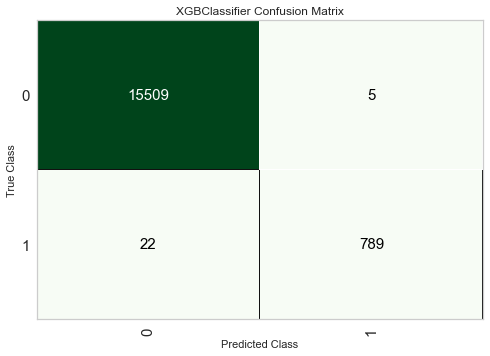

In [89]:
pyclf.plot_model(best_model, plot="confusion_matrix")

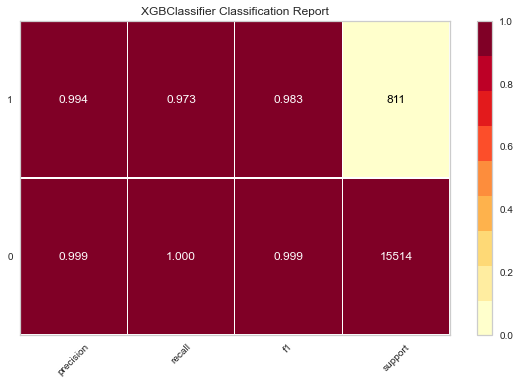

In [93]:
pyclf.plot_model(tuned_model, plot='class_report')

# 7. Conclusion